# FloPy

### Zonbud Example 1

This notebook demonstrates how to use the functions included in the zonbud utility to extract budget information from the cell by cell budget file using an array of zones.

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flopy.utils import ZoneBudget, CellBudgetFile, read_zbarray

# Set path to example datafiles
loadpth = os.path.join('..', 'data', 'zonbud_examples')

# Create CellBudgetFile object
cbc_file = os.path.join(loadpth, 'freyberg_mlt.cbc')
cbc_obj = CellBudgetFile(cbc_file)
nlay, nrow, ncol = cbc_obj.nlay, cbc_obj.nrow, cbc_obj.ncol

['', 'C:\\Anaconda\\python27.zip', 'C:\\Anaconda\\DLLs', 'C:\\Anaconda\\lib', 'C:\\Anaconda\\lib\\plat-win', 'C:\\Anaconda\\lib\\lib-tk', 'C:\\Anaconda', 'c:\\anaconda\\lib\\site-packages\\runipy-0.1.1-py2.7.egg', 'c:\\anaconda\\lib\\site-packages\\setuptools-20.2.2-py2.7.egg', 'C:\\Anaconda\\lib\\site-packages', 'C:\\Program Files (x86)\\ArcGIS\\Desktop10.3\\bin64', 'C:\\Program Files (x86)\\ArcGIS\\Desktop10.3\\ArcPy', 'C:\\Program Files (x86)\\ArcGIS\\Desktop10.3\\ArcToolBox\\Scripts', 'E:\\local_repo', 'E:\\local_repo\\SFRmaker', 'E:\\local_repo\\GIS_utils', 'E:\\local_repo\\pyemu', 'E:\\modflow\\ancillary\\python', 'C:\\Anaconda\\lib\\site-packages\\PIL', 'C:\\Anaconda\\lib\\site-packages\\Sphinx-1.2.3-py2.7.egg', 'C:\\Anaconda\\lib\\site-packages\\win32', 'C:\\Anaconda\\lib\\site-packages\\win32\\lib', 'C:\\Anaconda\\lib\\site-packages\\Pythonwin', 'C:\\Anaconda\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\jbellino\\.ipython', 'E:\\local_repo\\flopy_zonbud\\flopy']


### Read File Containing Zones

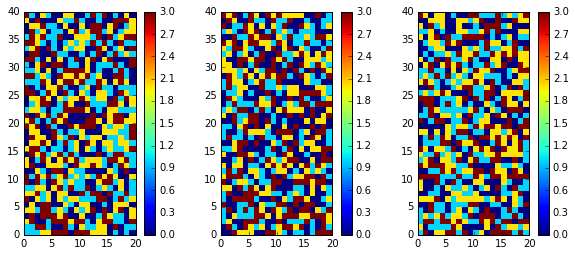

array([0, 1, 2, 3], dtype=int64)

In [2]:
# Define some very interesting zones
zone_file = os.path.join(loadpth, 'zonef_mlt')
zon = read_zbarray(zone_file)

fig = plt.figure(figsize=(10, 4))

for lay in range(nlay):
    ax = fig.add_subplot(1, nlay, lay+1)
    im = ax.pcolormesh(zon[lay, :, :])
    cbar = plt.colorbar(im)
    plt.gca().set_aspect('equal')
    
plt.show()
np.unique(zon)

### Extract Budget Information from ZoneBudget Object

At the core of the ZoneBudget object is a numpy structured array. The ZoneBudget class provides some wrapper functions to help us interogate the array and save it to disk.

In [3]:
# Create a ZoneBudget object and get the budget record array
zb = ZoneBudget(cbc_obj, zon, kstpkper=(0, 1096))
zb.get_budget()[0]

array([(1097.0, 0, 1096, 'STORAGE_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_IN', 0.0, 0.0, 86.14904022216797),
       (1097.0, 0, 1096, 'WELLS_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'RECHARGE_IN', 1306.9328665733337, 1299.4646787643433, 1277.0601153373718),
       (1097.0, 0, 1096, 'ZONE_0_IN', 4802.644836425781, 3535.9047956466675, 3882.708930850029),
       (1097.0, 0, 1096, 'ZONE_1_IN', 0.0, 3485.947250366211, 3202.0619506835938),
       (1097.0, 0, 1096, 'ZONE_2_IN', 3823.0936737060547, 0.0, 2978.4641098976135),
       (1097.0, 0, 1096, 'ZONE_3_IN', 3579.748610496521, 3084.417018890381, 0.0),
       (1097.0, 0, 1096, 'TOTAL_IN', 13512.41998720169, 11405.733743667603, 11426.444146990776),
       (1097.0, 0, 1096, 'STORAGE_OUT', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_OUT', 101.54193305969238, 232.463134765625, 204.33761596679688),
       (1097.0, 0, 1096, 'WELLS_OUT', 2656.7999267578125, 0.0, 0.0),
       (1097.0, 0, 1096, 'RECHARGE_OUT', 0.

In [4]:
# Look at a subset of fluxes
records = ['RECHARGE_IN', 'ZONE_1_IN', 'ZONE_3_IN']
bud = zb.get_budget()[0]
rowidx = np.in1d(bud['record'], records)
bud[rowidx]

array([ (1097.0, 0, 1096, 'RECHARGE_IN', 1306.9328665733337, 1299.4646787643433, 1277.0601153373718),
       (1097.0, 0, 1096, 'ZONE_1_IN', 0.0, 3485.947250366211, 3202.0619506835938),
       (1097.0, 0, 1096, 'ZONE_3_IN', 3579.748610496521, 3084.417018890381, 0.0)], 
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('record', 'S50'), ('ZONE_1', '<f8'), ('ZONE_2', '<f8'), ('ZONE_3', '<f8')])

In [5]:
# Look at fluxes in from zone 2
records = ['RECHARGE_IN', 'ZONE_1_IN', 'ZONE_3_IN']
zones = ['ZONE_2']
bud = zb.get_budget()[0]
rowidx = np.in1d(bud['record'], records)
bud[zones][rowidx]

array([(1299.4646787643433,), (3485.947250366211,), (3084.417018890381,)], 
      dtype=[('ZONE_2', '<f8')])

In [6]:
# Look at all of the mass-balance records
records = ['TOTAL_IN', 'TOTAL_OUT', 'IN-OUT', 'PERCENT_DISCREPANCY']
rowidx = np.in1d(bud['record'], records)
bud[rowidx]

array([ (1097.0, 0, 1096, 'TOTAL_IN', 13512.41998720169, 11405.733743667603, 11426.444146990776),
       (1097.0, 0, 1096, 'TOTAL_OUT', 13512.432970046997, 11405.73255777359, 11426.435069084167),
       (1097.0, 0, 1096, 'IN-OUT', -0.012982845306396484, 0.0011858940124511719, 0.009077906608581543),
       (1097.0, 0, 1096, 'PERCENT_DISCREPANCY', -9.608078406150355e-05, 1.0397350146459011e-05, 7.94465023225262e-05)], 
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('record', 'S50'), ('ZONE_1', '<f8'), ('ZONE_2', '<f8'), ('ZONE_3', '<f8')])

### Easily Convert Units
The ZoneBudget class provides methods for using mathematical operators and returns a new copy of the object.

In [7]:
cfd = ZoneBudget(cbc_obj, zon, kstpkper=(0, 0))
cfdbud = cfd.get_budget()[0]
print('cubic feet/day', cfdbud[6]['ZONE_1'])

mgd = cfd*(7.48052/1000000)
mgdbud = mgd.get_budget()[0]
print('million gallons/day', mgdbud[6]['ZONE_1'])

cubic feet/day 4680.23335648
million gallons/day 0.0350105792278


### Alias Names
A dictionary of {zone: "alias"} pairs can be passed to replace the typical `ZONE_X` fieldnames of the ZoneBudget structured array.

In [8]:
aliases = {1: 'SURF', 2:'CONF', 3: 'UFA'}
zb = ZoneBudget(cbc_obj, zon, totim=[1097.], aliases=aliases)
zb.get_budget()[0]

array([(1097.0, 0, 1096, 'STORAGE_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_IN', 0.0, 0.0, 86.14904022216797),
       (1097.0, 0, 1096, 'WELLS_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'RECHARGE_IN', 1306.9328665733337, 1299.4646787643433, 1277.0601153373718),
       (1097.0, 0, 1096, 'ZONE_0_IN', 4802.644836425781, 3535.9047956466675, 3882.708930850029),
       (1097.0, 0, 1096, 'SURF_IN', 0.0, 3485.947250366211, 3202.0619506835938),
       (1097.0, 0, 1096, 'CONF_IN', 3823.0936737060547, 0.0, 2978.4641098976135),
       (1097.0, 0, 1096, 'UFA_IN', 3579.748610496521, 3084.417018890381, 0.0),
       (1097.0, 0, 1096, 'TOTAL_IN', 13512.41998720169, 11405.733743667603, 11426.444146990776),
       (1097.0, 0, 1096, 'STORAGE_OUT', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_OUT', 101.54193305969238, 232.463134765625, 204.33761596679688),
       (1097.0, 0, 1096, 'WELLS_OUT', 2656.7999267578125, 0.0, 0.0),
       (1097.0, 0, 1096, 'RECHARGE_OUT', 0.0, 0.0,

## Return the Budgets as a Pandas DataFrame
Set "kstpkper" and "totim" keyword args to None (or omit) to return all times.
The `get_dataframes()` method will return a DataFrame multi-indexed on "totim" and "record".

In [9]:
zb = ZoneBudget(cbc_obj, zon, kstpkper=None, totim=None)
zb_mgd = zb * (7.4808/1000000)
zb_mgd.get_dataframes()

ZONE_1        ZONE_2        ZONE_3
totim  record                                                       
1.0    CONSTANT_HEAD_IN     0.000000e+00  0.000000e+00  0.000000e+00
       CONSTANT_HEAD_OUT    2.853891e-03  5.536720e-03  4.808256e-03
       IN-OUT               6.981366e-03  9.027949e-03  4.623198e-03
       PERCENT_DISCREPANCY  4.514059e-05  5.976885e-05  3.047828e-05
       RECHARGE_IN          1.182344e-02  1.175588e-02  1.155319e-02
       RECHARGE_OUT         0.000000e+00  0.000000e+00  0.000000e+00
       STORAGE_IN           0.000000e+00  0.000000e+00  0.000000e+00
       STORAGE_OUT          0.000000e+00  0.000000e+00  0.000000e+00
       TOTAL_IN             1.191874e-01  1.175098e-01  1.157866e-01
       TOTAL_OUT            1.122061e-01  1.084818e-01  1.111634e-01
       WELLS_IN             0.000000e+00  0.000000e+00  0.000000e+00
       WELLS_OUT            0.000000e+00  0.000000e+00  0.000000e+00
       ZONE_0_IN            3.752095e-02  3.686360e-02  4.241555e-02
       ZONE_0_OUT           4.167765e-02  3.841170e-02  3.801188e-02
       ZONE_1_IN            0.000000e+00  3.537822e-02  3.229632e-02
       ZONE_1_OUT           0.000000e+00  3.501189e-02  3.483116e-02
       ZONE_2_IN            3.501189e-02  0.000000e+00  2.952150e-02
       ZONE_2_OUT           3.537822e-02  0.000000e+00  3.351206e-02
       ZONE_3_IN            3.483116e-02  3.351206e-02  0.000000e+00
       ZONE_3_OUT           3.229632e-02  2.952150e-02  0.000000e+00
2.0    CONSTANT_HEAD_IN     0.000000e+00  0.000000e+00  0.000000e+00
       CONSTANT_HEAD_OUT    2.831799e-03  5.504577e-03  4.774879e-03
       IN-OUT               6.719027e-03  6.729497e-03  4.188144e-03
       PERCENT_DISCREPANCY  4.207085e-05  4.337520e-05  2.681747e-05
       RECHARGE_IN          1.210851e-02  1.203931e-02  1.183174e-02
       RECHARGE_OUT         0.000000e+00  0.000000e+00  0.000000e+00
       STORAGE_IN           1.239540e-03  1.081680e-03  1.115860e-03
       STORAGE_OUT          5.629237e-05  5.536649e-05  6.681886e-05
       TOTAL_IN             1.228334e-01  1.194265e-01  1.189234e-01
       TOTAL_OUT            1.161144e-01  1.126970e-01  1.147352e-01
...                                  ...           ...           ...
1096.0 WELLS_IN             0.000000e+00  0.000000e+00  0.000000e+00
       WELLS_OUT            5.887964e-03  0.000000e+00  0.000000e+00
       ZONE_0_IN            3.404783e-02  3.017752e-02  3.652699e-02
       ZONE_0_OUT           3.702571e-02  3.271562e-02  3.288243e-02
       ZONE_1_IN            0.000000e+00  2.868035e-02  2.818215e-02
       ZONE_1_OUT           0.000000e+00  3.065565e-02  3.135065e-02
       ZONE_2_IN            3.065565e-02  0.000000e+00  2.383451e-02
       ZONE_2_OUT           2.868035e-02  0.000000e+00  2.727270e-02
       ZONE_3_IN            3.135065e-02  2.727270e-02  0.000000e+00
       ZONE_3_OUT           2.818215e-02  2.383451e-02  0.000000e+00
1097.0 CONSTANT_HEAD_IN     0.000000e+00  0.000000e+00  6.444637e-04
       CONSTANT_HEAD_OUT    7.596149e-04  1.739010e-03  1.528609e-03
       IN-OUT              -9.712207e-08  8.871436e-09  6.791000e-08
       PERCENT_DISCREPANCY -7.187611e-10  7.778050e-11  5.943234e-10
       RECHARGE_IN          9.776903e-03  9.721035e-03  9.553431e-03
       RECHARGE_OUT         0.000000e+00  0.000000e+00  0.000000e+00
       STORAGE_IN           0.000000e+00  0.000000e+00  0.000000e+00
       STORAGE_OUT          0.000000e+00  0.000000e+00  0.000000e+00
       TOTAL_IN             1.010837e-01  8.532401e-02  8.547894e-02
       TOTAL_OUT            1.010838e-01  8.532400e-02  8.547888e-02
       WELLS_IN             0.000000e+00  0.000000e+00  0.000000e+00
       WELLS_OUT            1.987499e-02  0.000000e+00  0.000000e+00
       ZONE_0_IN            3.592763e-02  2.645140e-02  2.904577e-02
       ZONE_0_OUT           3.041755e-02  3.270390e-02  3.409698e-02
       ZONE_1_IN            0.000000e+00  2.607767e-02  2.395399e-02
       ZONE_1_OUT           0.00

In [10]:
# Slice the multi-index dataframe

df = zb.get_dataframes()
dateidx1 = 1092.
dateidx2 = 1097.
records = ['RECHARGE_IN', 'CONSTANT_HEAD_IN']
df.loc[(slice(dateidx1, dateidx2), records), :][['ZONE_1', 'ZONE_2']]

ZONE_1       ZONE_2
totim  record                                    
1092.0 CONSTANT_HEAD_IN     0.000000     0.000000
       RECHARGE_IN       1528.642464  1519.907364
1093.0 CONSTANT_HEAD_IN     0.000000     0.000000
       RECHARGE_IN       1067.698002  1061.596870
1094.0 CONSTANT_HEAD_IN     0.000000     0.000000
       RECHARGE_IN       1028.030455  1022.155995
1095.0 CONSTANT_HEAD_IN     0.000000     0.000000
       RECHARGE_IN       1272.534299  1265.262674
1096.0 CONSTANT_HEAD_IN     0.000000     0.000000
       RECHARGE_IN       1553.325272  1544.449127
1097.0 CONSTANT_HEAD_IN     0.000000     0.000000
       RECHARGE_IN       1306.932867  1299.464679

In [11]:
# Pass "start_datetime" and "timeunit" keyword arguments to return
# a dataframe with a datetime multi-index

df = zb.get_dataframes(start_datetime='1970-01-01', timeunit='D')
dateidx1 = pd.Timestamp('1972-12-01')
dateidx2 = pd.Timestamp('1972-12-06')
records = ['RECHARGE_IN', 'CONSTANT_HEAD_IN']
df.loc[(slice(dateidx1, dateidx2), records), :][['ZONE_1', 'ZONE_2']]

ZONE_1       ZONE_2
datetime   record                                    
1972-12-01 CONSTANT_HEAD_IN     0.000000     0.000000
           RECHARGE_IN       2097.740269  2085.753181
1972-12-02 CONSTANT_HEAD_IN     0.000000     0.000000
           RECHARGE_IN       1901.835418  1890.967787
1972-12-03 CONSTANT_HEAD_IN     0.000000     0.000000
           RECHARGE_IN       1417.822504  1409.720661
1972-12-04 CONSTANT_HEAD_IN     0.000000     0.000000
           RECHARGE_IN       1517.466474  1508.795237
1972-12-05 CONSTANT_HEAD_IN     0.000000     0.000000
           RECHARGE_IN       2009.126925  1997.646200
1972-12-06 CONSTANT_HEAD_IN     0.000000     0.000000
           RECHARGE_IN       2078.503346  2066.626184

### Write Budget Output to CSV

We can write the resulting recarray to a csv with the .to_csv() method of the Budget object.

In [12]:
ZoneBudget(cbc_obj, zon, kstpkper=[(0, 1095), (0, 1096)]).to_csv(os.path.join(loadpth, 'zonbud.csv'))

# Read the file in to see the contents
fname = os.path.join(loadpth, 'zonbud.csv')
try:
    import pandas as pd
    print(pd.read_csv(fname).to_string(index=True))
except:
    with open(fname, 'r') as f:
        for line in f.readlines():
            print('\t'.join(line.split(',')))

     totim  time_step  stress_period               record        ZONE_1        ZONE_2        ZONE_3
0   1096.0          0           1095           STORAGE_IN     59.167399     50.274390     62.397771
1   1096.0          0           1095     CONSTANT_HEAD_IN      0.000000      0.000000      2.494755
2   1096.0          0           1095             WELLS_IN      0.000000      0.000000      0.000000
3   1096.0          0           1095          RECHARGE_IN   1553.325272   1544.449127   1517.820694
4   1096.0          0           1095            ZONE_0_IN   4551.361713   4033.995799   4882.764688
5   1096.0          0           1095            ZONE_1_IN      0.000000   3833.860977   3767.264107
6   1096.0          0           1095            ZONE_2_IN   4097.910420      0.000000   3186.090844
7   1096.0          0           1095            ZONE_3_IN   4190.815559   3645.692362      0.000000
8   1096.0          0           1095             TOTAL_IN  14452.580364  13108.272655  13418.832859
